In [83]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

# Suppressing annoying harmless error
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)
warnings.simplefilter('ignore')

In [84]:
# We read the consumer price index (CPI) data from this website: https://fred.stlouisfed.org/series/CPIAUCSL
cpi_data = pd.read_excel('CPIAUCSL.xls', skiprows=10)

# Remove NA's
cpi_data.dropna(inplace=True)

In [85]:
cpi_data.head()

,observation_date,CPIAUCSL
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [86]:
# Take the observation_date column and convert it to an index to make it easier to plot
# Drop the observation_date after converting
cpi_data.index = pd.to_datetime(cpi_data.observation_date)
cpi_data.drop(['observation_date'], axis=1, inplace=True)

# Rename the CPIAUCSL column name to a simpler name like cpi
cpi_data.rename(columns={'CPIAUCSL': 'cpi'}, inplace=True)
cpi_data.head()

,cpi
observation_date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


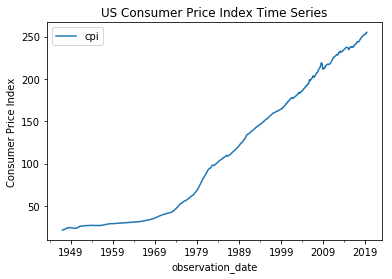

In [87]:
# Plot the raw CPI data with the dates as the index
cpi_data.plot()
plt.title('US Consumer Price Index Time Series')
plt.ylabel('Consumer Price Index')
plt.show()

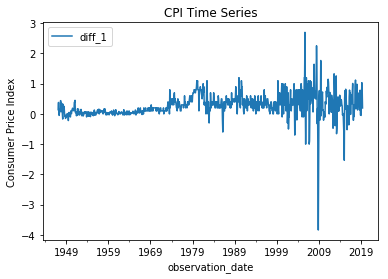

In [88]:
# Here we induce stationarity by calcluating the difference between current and previous values
# and plot the difference
cpi_data['diff_1'] = cpi_data.cpi - cpi_data.cpi.shift()
cpi_data.plot(y='diff_1')
plt.title('CPI Time Series')
plt.ylabel("Consumer Price Index")
plt.show()

Text(0.5, 1.0, 'US CPI PACF')

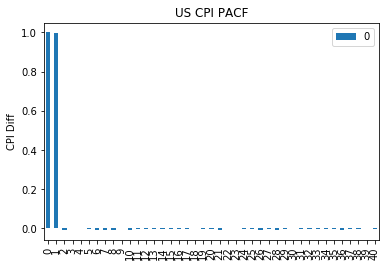

In [89]:
# Partial Auto Corrrelation Factor
# On the original values of CPI

from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(cpi_data.cpi))
x_acf.plot(kind='bar')
plt.ylabel('CPI Diff')
plt.title("US CPI PACF")

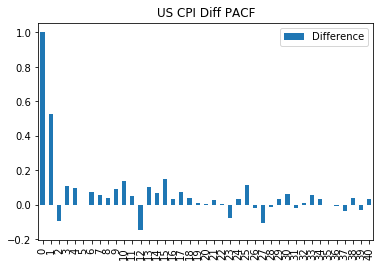

In [90]:
# Partial Auto Corrrelation Factor
# after inducing staionarity in CPI values

x_acf = pd.DataFrame(pacf(cpi_data.diff_1[1:]))
x_acf.plot(kind='bar')
plt.title("US CPI Diff PACF")
plt.legend(['Difference'])

In [91]:
cpi_data.head()

,cpi,diff_1
observation_date,,
1947-01-01,21.48,NaN
1947-02-01,21.62,0.14
1947-03-01,22.00,0.38
1947-04-01,22.00,0.00
1947-05-01,21.95,-0.05


In [92]:
# Run various ARIMA models to see which p, d and q values fit the best
# Pick the one with lowest AIC

from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(cpi_data.cpi, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                  D.cpi   No. Observations:                  868
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -407.280
Method:                           css   S.D. of innovations              0.387
Date:                Thu, 27 Jun 2019   AIC                            818.560
Time:                        18:55:31   BIC                            828.093
Sample:                    02-01-1947   HQIC                           822.208
                         - 05-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2692      0.013     20.503      0.000       0.243       0.295
Residuals Description
count    8.680000e+02
mean     4.513444e-09
std      3.870717e-01
min     -4.111211e+00
25%     -2.107108e-01

In [93]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(cpi_data.cpi, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                              ARMA Model Results                              
Dep. Variable:                    cpi   No. Observations:                  869
Model:                     ARMA(1, 0)   Log Likelihood                -588.436
Method:                       css-mle   S.D. of innovations              0.471
Date:                Thu, 27 Jun 2019   AIC                           1182.873
Time:                        18:55:32   BIC                           1197.175
Sample:                    01-01-1947   HQIC                          1188.345
                         - 05-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        147.1748        nan        nan        nan         nan         nan
ar.L1.cpi      1.0000        nan        nan        nan         nan         nan
                                    Roots           

In [ ]:
# With d = 0 this model returns error. Need to investigate

from statsmodels.tsa.arima_model import ARIMA
model_101 = ARIMA(cpi_data.cpi, order=(1,0,1))
model_101_fit = model.fit(disp=0)
print(model_101_fit.summary())
print('Residuals Description')
print(model_101_fit.resid.describe())

In [95]:
from statsmodels.tsa.arima_model import ARIMA
model_111 = ARIMA(cpi_data.cpi, order=(1,1,1))
model_111_fit = model_111.fit()
print(model_111_fit.summary())
print('Residuals Description')
print(model_111_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                  D.cpi   No. Observations:                  868
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -259.683
Method:                       css-mle   S.D. of innovations              0.326
Date:                Thu, 27 Jun 2019   AIC                            527.365
Time:                        18:55:50   BIC                            546.430
Sample:                    02-01-1947   HQIC                           534.661
                         - 05-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2689      0.021     12.536      0.000       0.227       0.311
ar.L1.D.cpi     0.3701      0.058      6.380      0.000       0.256       0.484
ma.L1.D.cpi     0.2210      0.061      3.615    

In [96]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(cpi_data.cpi, order=(5,1,5))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                  D.cpi   No. Observations:                  868
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -227.651
Method:                       css-mle   S.D. of innovations              0.314
Date:                Thu, 27 Jun 2019   AIC                            479.303
Time:                        18:56:00   BIC                            536.497
Sample:                    02-01-1947   HQIC                           501.189
                         - 05-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2604      0.086      3.044      0.002       0.093       0.428
ar.L1.D.cpi     1.0274      0.228      4.500      0.000       0.580       1.475
ar.L2.D.cpi    -0.7594      0.394     -1.929    

Text(0.5, 1.0, 'Histogram of CPI Residuals')

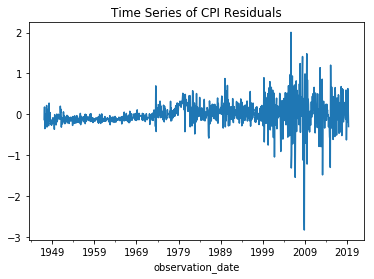

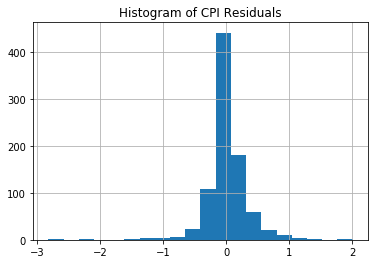

In [97]:
# Plot the residuals i.e the actual - predicted

residuals = pd.DataFrame(model_111_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of CPI Residuals')

residuals.hist(bins=20)
plt.title('Histogram of CPI Residuals')

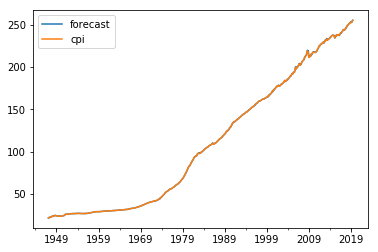

In [98]:
# ARIMA model has a function to plot the forecasted (predicted) value with original value
model_fit.plot_predict(dynamic=False)
plt.show()

In [111]:
cpi_data[cpi_data.isnull().any(axis=1)]

,cpi,diff_1
observation_date,,
1947-01-01,21.48,NaN


In [115]:
(cpi_data.cpi < 0).sum()

0

In [62]:
cpi_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 869 entries, 1947-01-01 to 2019-05-01
Data columns (total 2 columns):
cpi       869 non-null float64
diff_1    868 non-null float64
dtypes: float64(2)
memory usage: 20.4 KB


In [64]:
# Cross validate our model by splitting training and testing datasets at a 70-30 split ratio

from statsmodels.tsa.stattools import acf

# Create Training and Test
train_cpi = cpi_data.cpi[:650]
test_cpi = cpi_data.cpi[650:]

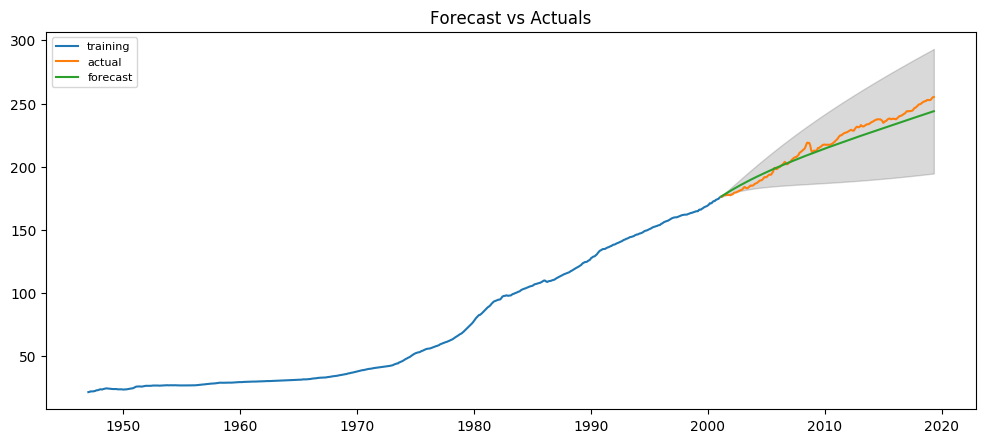

In [73]:
# Build Model and plot training versus actual versus forecast

model = ARIMA(train_cpi, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(test_size[0], alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_cpi.index)
lower_series = pd.Series(conf[:, 0], index=test_cpi.index)
upper_series = pd.Series(conf[:, 1], index=test_cpi.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_cpi, label='training')
plt.plot(test_cpi, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()